# Import

In [1]:
import numpy as np
import monai
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import torch
import time
import torch.nn.functional as F # Contains some additional functions such as activations
from torch.autograd import Variable
import torch.nn as nn # Contains all the functions we need to to train our network
import torch.nn.functional as F # Contains some additional functions such as activations
from torch.utils.data import Dataset, DataLoader, random_split
import sys
sys.path.append('./')

from torch import nn
import torch.nn.functional as F
from hparam import hparams as hp
import torchio as tio
from torchio.transforms import (
    RandomFlip,
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise,
    RandomMotion,
    RandomBiasField,
    RandomGamma,
    RescaleIntensity,
    Resample,
    ToCanonical,
    ZNormalization,
    CropOrPad,
    HistogramStandardization,
    OneOf,
    Compose,
    OneHot,
    EnsureShapeMultiple
)
from hparam import hparams as hp
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#sys.stdout = open('recode.log', mode = 'w',encoding='utf-8')

In [2]:
print('batch_size: ', hp.batch_size)
print('total_epochs: ', hp.total_epochs)
print('debug: ', hp.debug)

batch_size:  16
total_epochs:  60
debug:  True


## Useful functions

In [3]:
class MedData(torch.utils.data.Dataset):
    def __init__(self, image_dir_IOP, label_dir_IOP,image_dir_Guys, label_dir_Guys, 
                 image_dir_HH, label_dir_HH, train_val_ratio, batch_size):
        self.subjects = []
        self.X_IOP_ex = np.load(image_dir_IOP)
        self.y_IOP_ex = np.load(label_dir_IOP)
        self.X_Guys_ex = np.load(image_dir_Guys)
        self.y_Guys_ex = np.load(label_dir_Guys)
        self.X_HH_ex = np.load(image_dir_HH)
        self.y_HH_ex = np.load(label_dir_HH)
        self.train_val_ratio = train_val_ratio
        self.batch_size = batch_size
        self.preprocess = None
        self.transform = None

    def load_data(self, file_name):
        if file_name == 'IOP':
            X_train = torch.reshape(torch.tensor(self.X_IOP_ex), (self.X_IOP_ex.shape[0], 1, self.X_IOP_ex.shape[1],
                                                                self.X_IOP_ex.shape[2], self.X_IOP_ex.shape[3]))
            y_train = torch.reshape(torch.tensor(self.y_IOP_ex), (self.y_IOP_ex.shape[0], 1, self.y_IOP_ex.shape[1],
                                                                self.y_IOP_ex.shape[2], self.y_IOP_ex.shape[3]))
        elif file_name == 'Guys':
            X_train = torch.reshape(torch.tensor(self.X_Guys_ex), (self.X_Guys_ex.shape[0], 1, self.X_Guys_ex.shape[1],
                                                                self.X_Guys_ex.shape[2], self.X_Guys_ex.shape[3]))
            y_train = torch.reshape(torch.tensor(self.y_Guys_ex), (self.y_Guys_ex.shape[0], 1, self.y_Guys_ex.shape[1],
                                                                self.y_Guys_ex.shape[2], self.y_Guys_ex.shape[3]))
        elif file_name == 'HH':
            X_train = torch.reshape(torch.tensor(self.X_HH_ex), (self.X_HH_ex.shape[0], 1, self.X_HH_ex.shape[1],
                                                                  self.X_HH_ex.shape[2], self.X_HH_ex.shape[3]))
            y_train = torch.reshape(torch.tensor(self.y_HH_ex), (self.y_HH_ex.shape[0], 1, self.y_HH_ex.shape[1],
                                                                 self.y_HH_ex.shape[2], self.y_HH_ex.shape[3]))
        
        return X_train, y_train

    def prepare_data(self):
        X_train_IOP, y_train_IOP = self.load_data('IOP')
        for (image, label) in zip(X_train_IOP, y_train_IOP):
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image),
                label=tio.LabelMap(tensor=label),
            )
            self.subjects.append(subject)

        X_train_Guys, y_train_Guys = self.load_data('Guys')
        for (image, label) in zip(X_train_Guys, y_train_Guys):
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image),
                label=tio.LabelMap(tensor=label),
            )
            self.subjects.append(subject)

        X_train_HH, y_train_HH = self.load_data('HH')
        for (image, label) in zip(X_train_HH, y_train_HH):
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image),
                label=tio.LabelMap(tensor=label),
            )
            self.subjects.append(subject)

    def get_max_shape(self, subjects):
        dataset = tio.SubjectsDataset(subjects)
        shapes = np.array([s.spatial_shape for s in dataset])
        return shapes.max(axis=0)

    def get_augmentation_transform(self):
        auegmentation_transform = Compose([
            #OneOf({
            #    RandomAffine(): 0.8, # Apply a random affine transformation to the image
            #    RandomElasticDeformation(): 0.2,
            #}),
            RandomAffine(),
            RandomBiasField(p=0.5),
            RandomGamma(p=0.5),
            RandomNoise(p=0.5),
            # Randomly flip the image along 0: Sagittal (left-right) axis; 1: Coronal (anterior-posterior) axis; 2: Axial (superior-inferior) axis
            RandomFlip(axes=(0,)),
        ])

        return auegmentation_transform

    def get_preprocessing_transform(self):
        preprocessing_transform = Compose([
            Resample(1),  # resample the images to a common resolution
            # Modify the field of view by cropping or padding to match a target shape.
            CropOrPad(self.get_max_shape(self.subjects),
                      padding_mode='reflect'),
            # U-Net Ensure that all values in the image shape are divisible by 16
            EnsureShapeMultiple(16),
            # Subtract mean and divide by standard deviation.
            ZNormalization(),
            OneHot(hp.out_channel + 1),  # one hot encoding
        ])

        return preprocessing_transform

    def setup(self, aug):
        num_subjects = len(self.subjects)
        num_train_subjects = int(round(num_subjects * self.train_val_ratio[0]))
        num_val_subjects = int(round(num_subjects * self.train_val_ratio[1]))
        num_test_subjects = num_subjects - num_train_subjects - num_val_subjects

        splits = num_train_subjects, num_val_subjects, num_test_subjects
        train_subjects, val_subjects, test_subjects = random_split(
            self.subjects, splits)

        self.preprocess = self.get_preprocessing_transform()
        augmentation = self.get_augmentation_transform()
        self.transform = Compose([self.preprocess, augmentation])

        if aug is True:
            self.train_set = tio.SubjectsDataset(
                train_subjects, transform=self.transform)
        else:
            self.train_set = tio.SubjectsDataset(
                train_subjects, transform=self.preprocess)
        self.val_set = tio.SubjectsDataset(
            val_subjects, transform=self.preprocess)
        self.test_set = tio.SubjectsDataset(
            test_subjects, transform=self.preprocess)

    def train_dataloader(self):
        return DataLoader(self.train_set, self.batch_size, shuffle=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, self.batch_size, shuffle=True, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_set, self.batch_size, shuffle=True, pin_memory=True)


# Load Data

In [5]:
image_dir_IOP = 'healthcare_data/brain_extraction/X_IOP.npy'
label_dir_IOP = 'healthcare_data/brain_extraction/y_IOP.npy'
image_dir_Guys = 'healthcare_data/brain_extraction/X_Guys.npy'
label_dir_Guys = 'healthcare_data/brain_extraction/y_Guys.npy'
image_dir_HH = 'healthcare_data/brain_extraction/X_HH.npy'
label_dir_HH = 'healthcare_data/brain_extraction/y_HH.npy'

dataset = MedData(image_dir_IOP, label_dir_IOP,image_dir_Guys, label_dir_Guys, 
                 image_dir_HH, label_dir_HH, [0.6, 0.2, 0.2], hp.batch_size)
dataset.prepare_data()
dataset.setup(hp.aug[1])
print('Training:  ', len(dataset.train_set))
print('Validation: ', len(dataset.val_set))
print('Test:      ', len(dataset.test_set))

train_dataloader = dataset.train_dataloader()
val_dataloader = dataset.val_dataloader()
test_dataloader = dataset.test_dataloader()

next(iter(val_dataloader))['image']['data'].shape,next(iter(val_dataloader))['label']['data'].shape

Training:   338
Validation:  113
Test:       113


(torch.Size([16, 1, 48, 128, 128]), torch.Size([16, 2, 48, 128, 128]))

# Data Preprocessing

In [4]:
image_dir_IOP = 'healthcare_data/brain_extraction/X_IOP.npy'
label_dir_IOP = 'healthcare_data/brain_extraction/y_IOP.npy'
image_dir_Guys = 'healthcare_data/brain_extraction/X_Guys.npy'
label_dir_Guys = 'healthcare_data/brain_extraction/y_Guys.npy'
image_dir_HH = 'healthcare_data/brain_extraction/X_HH.npy'
label_dir_HH = 'healthcare_data/brain_extraction/y_HH.npy'

In [43]:
X_IOP_ex = np.load(image_dir_HH)
y_IOP_ex = np.load(label_dir_HH)
X_IOP_ex.shape, y_IOP_ex.shape

((176, 40, 128, 128), (176, 40, 128, 128))

In [44]:
X_train = torch.reshape(torch.tensor(X_IOP_ex), (X_IOP_ex.shape[0], 1, X_IOP_ex.shape[1], X_IOP_ex.shape[2], X_IOP_ex.shape[3]))
#y_train = to_one_hot(y_IOP_ex, 2)
y_train = torch.reshape(torch.tensor(y_IOP_ex), (y_IOP_ex.shape[0], 1, y_IOP_ex.shape[1], y_IOP_ex.shape[2], y_IOP_ex.shape[3]))

In [45]:
brain = X_train[0]
label = y_train[0]
brain.shape, label.shape

(torch.Size([1, 40, 128, 128]), torch.Size([1, 40, 128, 128]))

In [46]:
subject = tio.Subject(
    image=tio.ScalarImage(tensor=brain),
    label=tio.LabelMap(tensor=label)
)

image shape:  torch.Size([1, 40, 128, 128])
label shape:  torch.Size([1, 40, 128, 128])


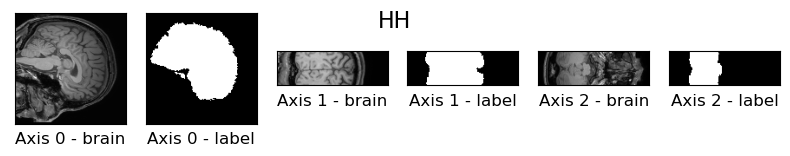

"\nplt.subplot(2,6,1)\nplt.imshow(brain[0][20,:,:])\nplt.axis('off')\nplt.subplot(2,6,2)\nplt.imshow(label[0][20,:,:])\nplt.axis('off')\nplt.subplot(2,6,3)\nplt.imshow(brain[0][:,20,:])\nplt.axis('off')\nplt.subplot(2,6,4)\nplt.imshow(label[0][:,20,:])\nplt.axis('off')\nplt.subplot(2,6,5)\nplt.imshow(brain[0][:,:,20])\nplt.axis('off')\nplt.subplot(2,6,6)\nplt.imshow(label[0][:,:,20])\nplt.axis('off')\nplt.subplot(2,6,7)\nplt.imshow(transformed_image[0][20,:,:])\nplt.axis('off')\nplt.subplot(2,6,8)\nplt.imshow(transformed_label[0][20,:,:])\nplt.axis('off')\nplt.subplot(2,6,9)\nplt.imshow(transformed_image[0][:,20,:])\nplt.axis('off')\nplt.subplot(2,6,10)\nplt.imshow(transformed_label[0][:,20,:])\nplt.axis('off')\nplt.subplot(2,6,11)\nplt.imshow(transformed_image[0][:,:,20])\nplt.axis('off')\nplt.subplot(2,6,12)\nplt.imshow(transformed_label[0][:,:,20])\nplt.axis('off')\n"

: 

In [47]:
transform = RandomFlip()
#transform = Resample(2)
#transform = OneHot(2)
#transform = CropOrPad(subject.spatial_shape)
#transform = EnsureShapeMultiple(16)
#transform = RandomElasticDeformation()
transformed_subject = transform(subject)
transformed_image = transformed_subject['image']['data']
transformed_label = transformed_subject['label']['data']
print('image shape: ', transformed_subject['image']['data'].shape)
print('label shape: ', transformed_subject['label']['data'].shape)

# Create a figure and set the size
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(8, 2))

# Replace these with your own images or NumPy arrays
image1 = brain[0][20,:,:]
image2 = label[0][20,:,:]
image3 = brain[0][:,20,:]
image4 = label[0][:,20,:]
image5 = brain[0][:,:,20]
image6 = label[0][:,:,20]

# Plot image1 and image2 with label "Pair 1"
axes[0].imshow(image1, cmap='gray')
axes[1].imshow(image2, cmap='gray')
axes[0].set_title("Axis 0 - brain", y=-0.25)
axes[1].set_title("Axis 0 - label", y=-0.25)

# Plot image3 and image4 with label "Pair 2"
axes[2].imshow(image3, cmap='gray')
axes[3].imshow(image4, cmap='gray')
axes[2].set_title("Axis 1 - brain", y=-0.8)
axes[3].set_title("Axis 1 - label", y=-0.8)

# Plot image5 and image6 with label "Pair 3"
axes[4].imshow(image5, cmap='gray')
axes[5].imshow(image6, cmap='gray')
axes[4].set_title("Axis 2 - brain", y=-0.8)
axes[5].set_title("Axis 2 - label", y=-0.8)


# Remove axis ticks
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('HH', fontsize=16, y=0.7)

# Display the images
plt.tight_layout()
plt.show()
"""
plt.subplot(2,6,1)
plt.imshow(brain[0][20,:,:])
plt.axis('off')
plt.subplot(2,6,2)
plt.imshow(label[0][20,:,:])
plt.axis('off')
plt.subplot(2,6,3)
plt.imshow(brain[0][:,20,:])
plt.axis('off')
plt.subplot(2,6,4)
plt.imshow(label[0][:,20,:])
plt.axis('off')
plt.subplot(2,6,5)
plt.imshow(brain[0][:,:,20])
plt.axis('off')
plt.subplot(2,6,6)
plt.imshow(label[0][:,:,20])
plt.axis('off')
plt.subplot(2,6,7)
plt.imshow(transformed_image[0][20,:,:])
plt.axis('off')
plt.subplot(2,6,8)
plt.imshow(transformed_label[0][20,:,:])
plt.axis('off')
plt.subplot(2,6,9)
plt.imshow(transformed_image[0][:,20,:])
plt.axis('off')
plt.subplot(2,6,10)
plt.imshow(transformed_label[0][:,20,:])
plt.axis('off')
plt.subplot(2,6,11)
plt.imshow(transformed_image[0][:,:,20])
plt.axis('off')
plt.subplot(2,6,12)
plt.imshow(transformed_label[0][:,:,20])
plt.axis('off')
"""

In [ ]:
# Define some transforms to apply to the image
transforms = tio.Compose([
    tio.Resample(1),    # Resample the image to 1 mm isotropic voxel size
    tio.RandomFlip(),   # Randomly flip the image along one or more axes
    tio.RandomAffine(), # Apply a random affine transformation to the image
    tio.ZNormalization(),    # Normalize the intensities of the image to zero mean and unit variance
    tio.RandomNoise(),  # Add random Gaussian noise to the image
])

# Apply the transforms to the subject
transformed_subject = transforms(subject)

In [ ]:
affine_transform = tio.RandomAffine()
transformed_tensor = affine_transform(brain)
plt.imshow(transformed_tensor[0][20,:,:])

In [ ]:
transform = tio.ZNormalization()  # ZNormalization is a subclass of NormalizationTransform
transformed = transform(temp)
plt.imshow(transformed[0][20,:,:])

In [ ]:
spatial_transforms = {
    tio.RandomElasticDeformation(): 0.2,
    tio.RandomAffine(): 0.8,
}
transform = tio.Compose([
    tio.OneOf(spatial_transforms, p=0.5),
    tio.RescaleIntensity(out_min_max=(0, 1)),
])

# Dataset

In [ ]:
class numpy_dataset(Dataset):  # Inherit from Dataset class
    def __init__(self, data, target):
        ## Add code here 
        self.data = data
        self.target = target

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)
    
train_dataset = numpy_dataset(X_train, y_train)
#val_dataset = numpy_dataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
#val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

# New 3D UNet

In [6]:
from three_d.unet3d import UNet3D
from three_d.residual_unet3d import Residual_UNet
from three_d.fcn3d import FCN_Net
from three_d.highresnet import HighRes3DNet
from three_d.densenet3d import SkipDenseNet3D
from three_d.densevoxelnet3d import DenseVoxelNet
from three_d.vnet3d import VNet
from three_d.unetr import UNETR

In [ ]:
#from models.three_d.residual_unet3d import UNet
#model = UNet(in_channels=hp.in_class, n_classes=hp.out_class+1, base_n_filter=2)

#from models.three_d.fcn3d import FCN_Net
#model = FCN_Net(in_channels =hp.in_class,n_class =hp.out_class+1)

#from models.three_d.highresnet import HighRes3DNet
#model = HighRes3DNet(in_channels=hp.in_class,out_channels=hp.out_class+1)

#from models.three_d.densenet3d import SkipDenseNet3D
#model = SkipDenseNet3D(in_channels=hp.in_class, classes=hp.out_class+1)

# from models.three_d.densevoxelnet3d import DenseVoxelNet
# model = DenseVoxelNet(in_channels=hp.in_class, classes=hp.out_class+1)

#from models.three_d.vnet3d import VNet
#model = VNet(in_channels=hp.in_class, classes=hp.out_class+1)

#from models.three_d.unetr import UNETR
#model = UNETR(img_shape=(hp.crop_or_pad_size), input_dim=hp.in_class, output_dim=hp.out_class+1)

# Train, Val, Test

In [7]:
def L2RegLoss(main_loss, x, target, mu, model):

    main_loss = main_loss(x, target)
    penalty = 0
    for i in model.parameters():
        penalty += torch.sum(i**2)
    J = main_loss + mu*penalty

    return J

In [8]:
def train(net, dataloader, optim, loss_func, epoch):
    net.train()  #Put the network in train mode
    total_loss = 0
    batches = 0
    
    start = time.time()
    for batch_idx, batch in enumerate(dataloader):

        if True: #hp.debug:
            if batch_idx >=5:
                break
        data = batch['image'][tio.DATA]
        target = batch['label'][tio.DATA]
        data, target = Variable(data).to(device), Variable(target).to(device)
        batches += 1

        # Training loop
        optim.zero_grad()
        pred = net(data) 
        target = target.to(torch.float32)
        loss = loss_func(pred ,target) #L2RegLoss(loss_func, pred, target, 0.0001,net)
        loss.backward()
        optim.step()
        
        total_loss += loss
        if batch_idx % 4 == 0: #Report stats every x batches
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (batch_idx+1) * len(data), len(dataloader.dataset),
                           100. * (batch_idx+1) / len(dataloader), loss.item()), flush=True)
    av_loss = total_loss / batches
    av_loss = av_loss.detach().cpu().numpy()
    print('\nTraining set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    total_time = time.time() - start
    print('Time taken for epoch = ', total_time)
    return av_loss

def val(net, val_dataloader, optim, loss_func, epoch):
    net.eval()  #Put the model in eval mode
    total_loss = 0    
    batches = 0
    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, batch in enumerate(val_dataloader):
            batches += 1
            data = batch['image'][tio.DATA]
            target = batch['label'][tio.DATA]
            data, target = Variable(data).to(device), Variable(target).to(device)
            # Eval steps
            optim.zero_grad()
            target = target.to(torch.float32)

            pred = net(data) 
            loss = loss_func(pred ,target)
            
            total_loss += loss
        av_loss = total_loss / batches
        
    av_loss = av_loss.detach().numpy()
    print('Validation set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    print('\n')
    return av_loss

## Train

In [9]:
def count_parameters(model: torch.nn.Module) -> int: # return type is int
    """ Returns the number of learnable parameters for a PyTorch model """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
net = UNet3D(in_channels=1, out_channels=2, init_features=16).to(device)

In [11]:
net

UNet3D(
  (encoder1): Sequential(
    (enc1conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (enc1norm1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (enc1norm2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (enc2norm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (enc2norm2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running

In [12]:
# Calculate the number of traininable params
print('Trainable params: ', count_parameters(net))

DiceCELoss = monai.losses.DiceCELoss() # : cross entropy + dice loss
Dice_Loss = monai.losses.DiceLoss(reduction='mean') #: dice loss
CrossE_loss = nn.CrossEntropyLoss() # cross entropy
BCE_loss = nn.BCELoss() # binary cross entropy

for i in ['DiceCELoss', 'Dice_Loss', 'CrossE_loss', 'BCE_loss']:
    print("Loss Function is", i)
    if i == 'DiceCELoss':
        class_loss = monai.losses.DiceCELoss()
    elif i == 'Dice_Loss':
        class_loss = monai.losses.DiceLoss(reduction='mean')
    elif i == 'CrossE_loss':
        class_loss = nn.CrossEntropyLoss()
    elif i == 'BCE_loss':
        class_loss = nn.BCELoss()
        
    optim = torch.optim.Adam(net.parameters(), lr = hp.init_lr)

    losses = []
    max_epochs = hp.total_epochs
    check_point = np.inf
    early_stop = 0
    for epoch in range(1, max_epochs+1):
        train_loss = train(net, train_dataloader, optim, class_loss, epoch)
        val_loss = val(net, val_dataloader, optim, class_loss, epoch)
        if val_loss < check_point:
            check_point = val_loss
            early_stop = 0
        else:
            early_stop += 1
        if early_stop >= 10:
            break
        losses.append([train_loss, val_loss])

    losses = np.array(losses).T
    print(losses.shape)
    its = np.linspace(1, max_epochs, max_epochs)

    plt.figure()
    plt.plot(its, losses[0,:])
    plt.plot(its, losses[1,:])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

Trainable params:  5647874
Loss Function is DiceCELoss
x:  torch.Size([16, 1, 48, 128, 128])
outputs:  torch.Size([16, 2, 48, 128, 128])
Train Epoch: 1 [16/338 (5%)]	Loss: 1.176963
x:  torch.Size([16, 1, 48, 128, 128])
outputs:  torch.Size([16, 2, 48, 128, 128])
x:  torch.Size([16, 1, 48, 128, 128])
outputs:  torch.Size([16, 2, 48, 128, 128])
x:  torch.Size([16, 1, 48, 128, 128])
outputs:  torch.Size([16, 2, 48, 128, 128])
x:  torch.Size([16, 1, 48, 128, 128])
outputs:  torch.Size([16, 2, 48, 128, 128])
Train Epoch: 1 [80/338 (23%)]	Loss: 0.997413

Training set: Average loss: 1.0814
Time taken for epoch =  472.51298546791077
x:  torch.Size([16, 1, 48, 128, 128])
outputs:  torch.Size([16, 2, 48, 128, 128])
x:  torch.Size([16, 1, 48, 128, 128])
outputs:  torch.Size([16, 2, 48, 128, 128])
x:  torch.Size([16, 1, 48, 128, 128])
outputs:  torch.Size([16, 2, 48, 128, 128])
x:  torch.Size([16, 1, 48, 128, 128])
outputs:  torch.Size([16, 2, 48, 128, 128])
x:  torch.Size([16, 1, 48, 128, 128])
o

KeyboardInterrupt: 

## Predict

In [ ]:
def predict(net, test_dataloader):
    pred_store = []
    true_store = []
         
    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, batch in enumerate(test_dataloader):
            data = batch['image'][tio.DATA]
            target = batch['label'][tio.DATA]
            data, target = Variable(data).to(device), Variable(target).to(device)
            # Complete validation loop here:
            target = target.to(torch.float32)
            pred = net(data) 
            #print(pred.shape)
            #print(np.argmax(pred.cpu().detach().numpy(), axis=1).shape)
            pred_store.extend(np.argmax(pred.cpu().detach().numpy(), axis=1))

            true_store.extend(np.argmax(target.cpu().detach().numpy(), axis=1))
    
    pred_store = torch.tensor(pred_store)
    pred_store = torch.reshape(pred_store.detach(), (pred_store.shape[0], 1, pred_store.shape[1], \
                                                            pred_store.shape[2], pred_store.shape[3]))
    pred_store = np.array(pred_store)

    true_store = torch.tensor(true_store)
    true_store = torch.reshape(true_store.detach(), (true_store.shape[0], 1, true_store.shape[1], \
                                                            true_store.shape[2], true_store.shape[3]))
    true_store = np.array(true_store)
    

    return pred_store, true_store

In [ ]:
pred, true = predict(net, test_dataloader)

In [ ]:
pred.shape, true.shape

In [ ]:
def dice(ground_truth, prediction):
    # Calculate the dice coefficient of the ground truth and the prediction
    intersect = np.sum(prediction[ground_truth == 1])*2.0
    dice_coeff =  intersect / (np.sum(prediction) + np.sum(ground_truth))
    return dice_coeff

In [ ]:
dice(true, pred)

In [ ]:
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean_batch")
dice_score = dice_metric(y_pred = torch.from_numpy(pred), y = torch.from_numpy(true))
torch.mean(dice_score).item()

In [ ]:
IoU_metric = monai.metrics.MeanIoU(include_background=True, reduction="mean_batch")
IoU_socre = IoU_metric(y_pred = torch.from_numpy(pred), y = torch.from_numpy(true))
torch.mean(IoU_socre).item()

## 尝试不同的loss function组合

## 尝试不同的深度

## 尝试不同的augmentation

## 尝试不同的超参数：batch size，crop_or_pad_size